In [1]:
#Adds higher directory to path, so we can access /ATS
import sys
sys.path.append("../")

from ATS.general import *
from ATS.QAQC import *

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import pyproj

# Set the DataFram in pandas to show all columns and 1000 rows. Display plots inline
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)

2022-01-06 18:31:52.354254: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-06 18:31:52.354308: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load, merge, and subset data

<Item title:"New_WR_Woody_Cover_BothHab_2022" type:Feature Layer Collection owner:Anooshi>
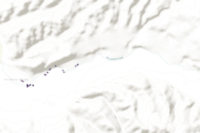

In [2]:
# Load data from arcGIS online
output = arcGIS_data_load('2bc6f3757c9e4871bdff546cfde7499f')

layer = output['data0']
records = output['table0']
feature_service = output['feature_service']

In [3]:
len(layer)

23

In [4]:
#Merge related records and feature
data = layer.merge(records, left_on='GlobalID', right_on='Ref_to_Points', how='inner')

data = data.drop(columns=['Ref_to_Points','GlobalID_x'])
data = data.rename(columns={'OBJECTID_x':'PointID','OBJECTID_y':'RecordID','GlobalID_y':'RecordGlobalID'})
data.head()

,PointID,Habitat,BHR_Site,Observer1,Observer2,SurveyDate,FldPntTyp,Comments,PlotCode,Azimuth,Year,SHAPE,RecordID,HeightCat,Species__scientific_name_,Cal_IPC_Rating,Native,RWQCB_Permit_Hydro,RWQCB_Permit_ACOE_Hydro,RecordGlobalID,Woody
0,1268,(New) Willow Riparian,SAC,Kurt Lutz,Roger Stephens,2021-08-03 02:31:18,Intended Habitat,Dead SALLAS for ht cat 2 and 3.,NEWR2,294,2020-2021,"{'x': 6184233.459057465, 'y': 2036877.58535438...",101,1,Bare Ground (none),None,None,None,None,49b343e3-805f-45c8-aa26-553e528f9b10,None
1,1270,(New) Willow Riparian,SAC,Kurt Lutz,Roger Stephens,2021-08-03 02:46:23,Intended Habitat,None,NEWR4,32,2020-2021,"{'x': 6184432.847110137, 'y': 2036899.34088830...",107,3,Salix laevigata,None,True,True,True,0dff7996-aea4-4ca5-8eca-d3c8e3ff61e3,True
2,1270,(New) Willow Riparian,SAC,Kurt Lutz,Roger Stephens,2021-08-03 02:46:23,Intended Habitat,None,NEWR4,32,2020-2021,"{'x': 6184432.847110137, 'y': 2036899.34088830...",108,2,Salix laevigata,None,True,True,True,bc2959da-c0c6-4d4c-8b04-e3637283f89e,True
3,1270,(New) Willow Riparian,SAC,Kurt Lutz,Roger Stephens,2021-08-03 02:46:23,Intended Habitat,None,NEWR4,32,2020-2021,"{'x': 6184432.847110137, 'y': 2036899.34088830...",109,3,Salix lasiolepis,None,True,True,True,7640d1ca-bba2-4b75-95de-c64bd4115819,True
4,1273,(New) Willow Riparian,SAC,Roger Stephens,Kurt Lutz,2021-08-03 00:05:59,Intended Habitat,None,NEWR7,313,2020-2021,"{'x': 6184866.362319216, 'y': 2037310.71440939...",118,2,Salix lasiolepis,None,True,True,True,58fc5728-3bdd-4d50-b9cf-eab40271963a,True


In [5]:
sub.groupby('Habitat').PlotCode.nunique()

NameError: name 'sub' is not defined

# Update Ratings and Catagories through API

In [6]:
############ Species Lists
pltDir = r"Script Support Files/SAC Master Plant Species List 20220106.xlsx"
pltSheet = "Master Plant Species"

verif = input("Current Plant Species List file location:\n"+pltDir+"\nCurrent Sheet Name:\n"+pltSheet+"\n\nIs this correct? (Y/N)")


if verif=="Y":
    # Will need to update this file locally on the G drive and change the sheet name
    pltLst = pd.read_excel(pltDir, pltSheet)

    #Clean lists
    for col in ['Native','Cal-IPC Rating','RWQCB and USACE Hydro List 1', 'RWQCB List (Included In Hydrophytic Cover) 2','Species', 'Woody Native Plant']:
        pltLst[col] = text_cleaner(pltLst[col])
    
    #Get CAL IPC High list
    Cal_IPC_H = pltLst.loc[pltLst['Cal-IPC Rating'] == "High", 'Species'].tolist()
    
    #Get CAL IPC Moderate list
    Cal_IPC_M = pltLst.loc[pltLst['Cal-IPC Rating'] == "Moderate", 'Species'].tolist()

    # Get native species list
    Native = pltLst.loc[pltLst["Native"]=="Native","Species"].tolist()

    # Get RWQCB Permit Hydro List
    RWQCB = pltLst.loc[pltLst["RWQCB and USACE Hydro List 1"]=="x","Species"].tolist()
    
    # Get RWQCB Permit / USACOE Hydro List
    RWQCB_USACE = pltLst.loc[pltLst["RWQCB List (Included In Hydrophytic Cover) 2"]=="x","Species"].tolist()
    
    # Get woody
    Woody = pltLst.loc[pltLst['Woody Native Plant'] == "x", 'Species'].tolist()
    
    print("Done")
    
else:
    print("\nChange directory and sheet in code")

Current Plant Species List file location:
Script Support Files/SAC Master Plant Species List 20220106.xlsx
Current Sheet Name:
Master Plant Species

Is this correct? (Y/N) Y

Done


In [8]:
#Update records
# Get all records
VC_records = feature_service.tables[0].query(return_all_records=True)

edits = []

#loop through each feature
for feature in VC_records.features:
    
    species = feature.attributes['Species__scientific_name_']
    update_flag = False

    if species in Cal_IPC_H:
        feature.attributes['Cal_IPC_Rating'] = 'High'
        update_flag = True

    if species in Cal_IPC_M:
        feature.attributes['Cal_IPC_Rating'] = 'Moderate'
        update_flag = True

    if species in Native:
        feature.attributes['Native'] = 'True'
        update_flag = True

    if species in RWQCB:
        feature.attributes['RWQCB_Permit_Hydro'] = 'True'
        update_flag = True

    if species in RWQCB_USACE:
        feature.attributes['RWQCB_Permit_ACOE_Hydro'] = 'True'
        update_flag = True
        
    if species in Woody:
        feature.attributes['Woody'] = 'True'
        update_flag = True

    #if an change was made, update through API
    if update_flag:
        edits.append(feature)

#send updates if edit was made
if edits:
    result = feature_service.tables[0].edit_features(updates=edits)

    #Check if update was successful
    fail_flag = False
    for item in result['updateResults']:
        if not item['success']:
            fail_flag = True
            print('Could not update feature, Object ID: ',item['objectId'])

    if not fail_flag:
        print('Successfully updated features')
        
else:
    print('No edits made')

Successfully updated features


# Subset Data

In [10]:
data.head()

,PointID,Habitat,BHR_Site,Observer1,Observer2,SurveyDate,FldPntTyp,Comments,PlotCode,Azimuth,Year,SHAPE,RecordID,HeightCat,Species__scientific_name_,Cal_IPC_Rating,Native,RWQCB_Permit_Hydro,RWQCB_Permit_ACOE_Hydro,RecordGlobalID,Woody
0,1268,(New) Willow Riparian,SAC,Kurt Lutz,Roger Stephens,2021-08-03 02:31:18,Intended Habitat,Dead SALLAS for ht cat 2 and 3.,NEWR2,294,2020-2021,"{'x': 6184233.459057465, 'y': 2036877.58535438...",101,1,Bare Ground (none),None,None,None,None,49b343e3-805f-45c8-aa26-553e528f9b10,None
1,1270,(New) Willow Riparian,SAC,Kurt Lutz,Roger Stephens,2021-08-03 02:46:23,Intended Habitat,None,NEWR4,32,2020-2021,"{'x': 6184432.847110137, 'y': 2036899.34088830...",107,3,Salix laevigata,None,True,True,True,0dff7996-aea4-4ca5-8eca-d3c8e3ff61e3,True
2,1270,(New) Willow Riparian,SAC,Kurt Lutz,Roger Stephens,2021-08-03 02:46:23,Intended Habitat,None,NEWR4,32,2020-2021,"{'x': 6184432.847110137, 'y': 2036899.34088830...",108,2,Salix laevigata,None,True,True,True,bc2959da-c0c6-4d4c-8b04-e3637283f89e,True
3,1270,(New) Willow Riparian,SAC,Kurt Lutz,Roger Stephens,2021-08-03 02:46:23,Intended Habitat,None,NEWR4,32,2020-2021,"{'x': 6184432.847110137, 'y': 2036899.34088830...",109,3,Salix lasiolepis,None,True,True,True,7640d1ca-bba2-4b75-95de-c64bd4115819,True
4,1273,(New) Willow Riparian,SAC,Roger Stephens,Kurt Lutz,2021-08-03 00:05:59,Intended Habitat,None,NEWR7,313,2020-2021,"{'x': 6184866.362319216, 'y': 2037310.71440939...",118,2,Salix lasiolepis,None,True,True,True,58fc5728-3bdd-4d50-b9cf-eab40271963a,True


In [11]:
#Add correctly named 'date' column

df = pd.DataFrame(data)
df['Observation_Date'] = data.SurveyDate


In [12]:
# Subset by year
sYear = input("Start Year? (YYYY)")
sub = year_subset(data, sYear)

Start Year? (YYYY) 2020

Analysis for 2020-10-01 07:00 UTC to 2021-10-01 07:00 UTC
Entries in Subset: 42


In [13]:
#  ^Subset count will not match what is on AGOL, it will be higher.

# QAQC

In [14]:
validate_domains(feature_service)



Table/Layer:  SAC_Both_Woody_Cover_Records


No Mismatches Found


Table/Layer:  SAC_Both_WR_Woody_Cover


No Mismatches Found


In [15]:
# Search for whitespaces and extra spaces
QAQC_whitespace(data, exclude_cols=['Comments'], objectID=['PointID'])



Analysis for: Observer2
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: PlotCode
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: RWQCB_Permit_ACOE_Hydro
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: RecordGlobalID
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: Species__scientific_name_
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: Native
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: SHAPE
No \xa0 characters found
No double spaces found
No triple spaces found
No trailing white space found


Analysis for: Habitat
No \xa0 characters found
No double spaces found
No triple sp

In [16]:
find_blank_entries(data, exclude_cols=['Cal_IPC_Rating','Observer2','RWQCB_Permit_ACOE_Hydro','RWQCB_Permit_Hydro','Comments','Native','Woody'])

No blank Habitat
No blank PlotCode
No blank BHR_Site
No blank FldPntTyp
No blank Year
No blank Observer1
No blank RecordGlobalID
No blank RecordID
No blank HeightCat
No blank SurveyDate
No blank Azimuth
No blank PointID
No blank Observation_Date
No blank Species__scientific_name_
No blank SHAPE


/home/user/SAC/../ATS/QAQC.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[plt_r,plt_c].set_xticklabels(r['DateString'], rotation='vertical')


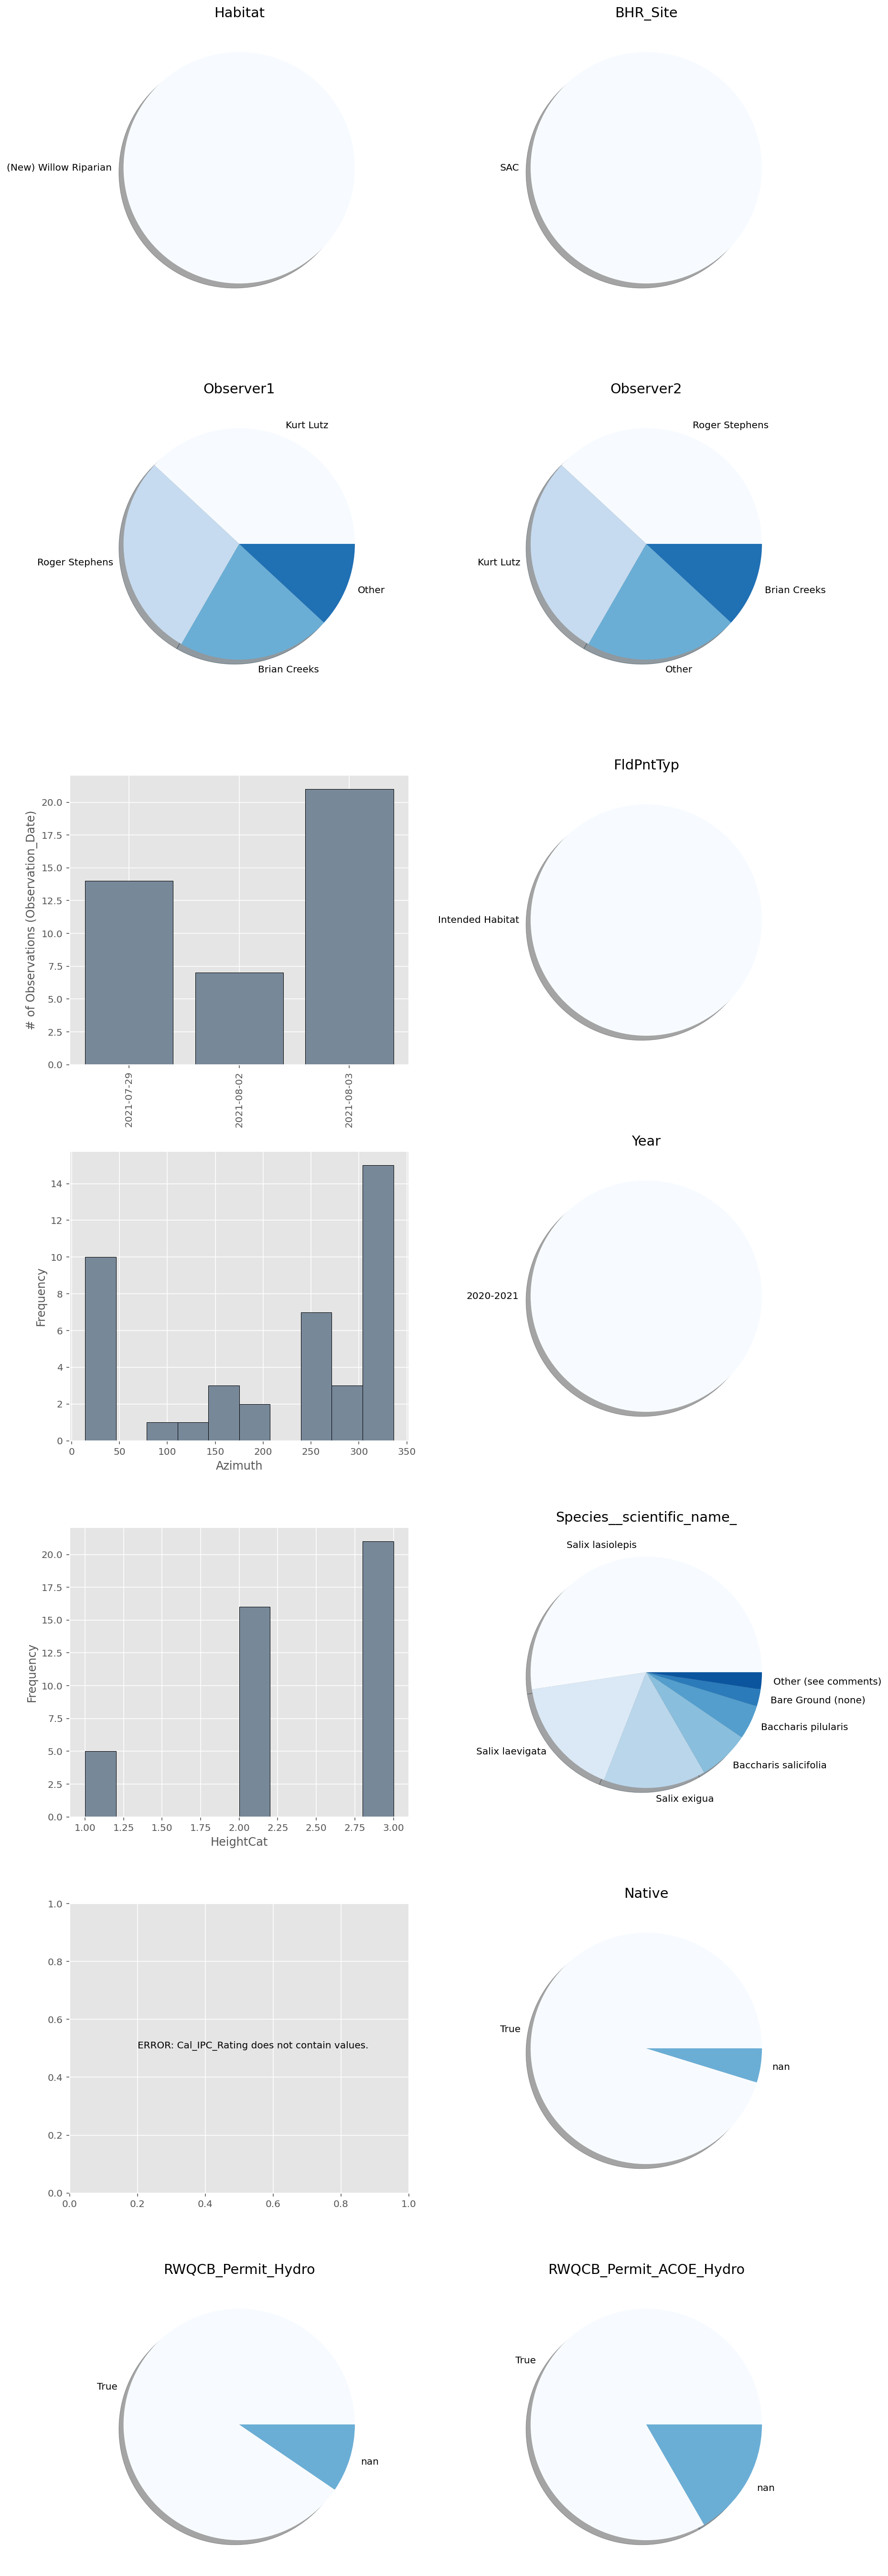

In [17]:
# histogram and pie charts for select columns
QAQC_plot(data,['Habitat', 'BHR_Site', 'Observer1', 'Observer2',
       'Observation_Date', 'FldPntTyp',   'Azimuth',
       'Year',  'HeightCat', 'Species__scientific_name_',
       'Cal_IPC_Rating', 'Native', 'RWQCB_Permit_Hydro',
       'RWQCB_Permit_ACOE_Hydro'])

ERROR: Native does not contain values.
ERROR: RWQCB_Permit_Hydro does not contain values.
ERROR: RWQCB_Permit_ACOE_Hydro does not contain values.
ERROR: Cal_IPC_Rating does not contain values.
ERROR: Habitat does not contain values.
ERROR: HeightCat does not contain values.
ERROR: Observer1 does not contain values.


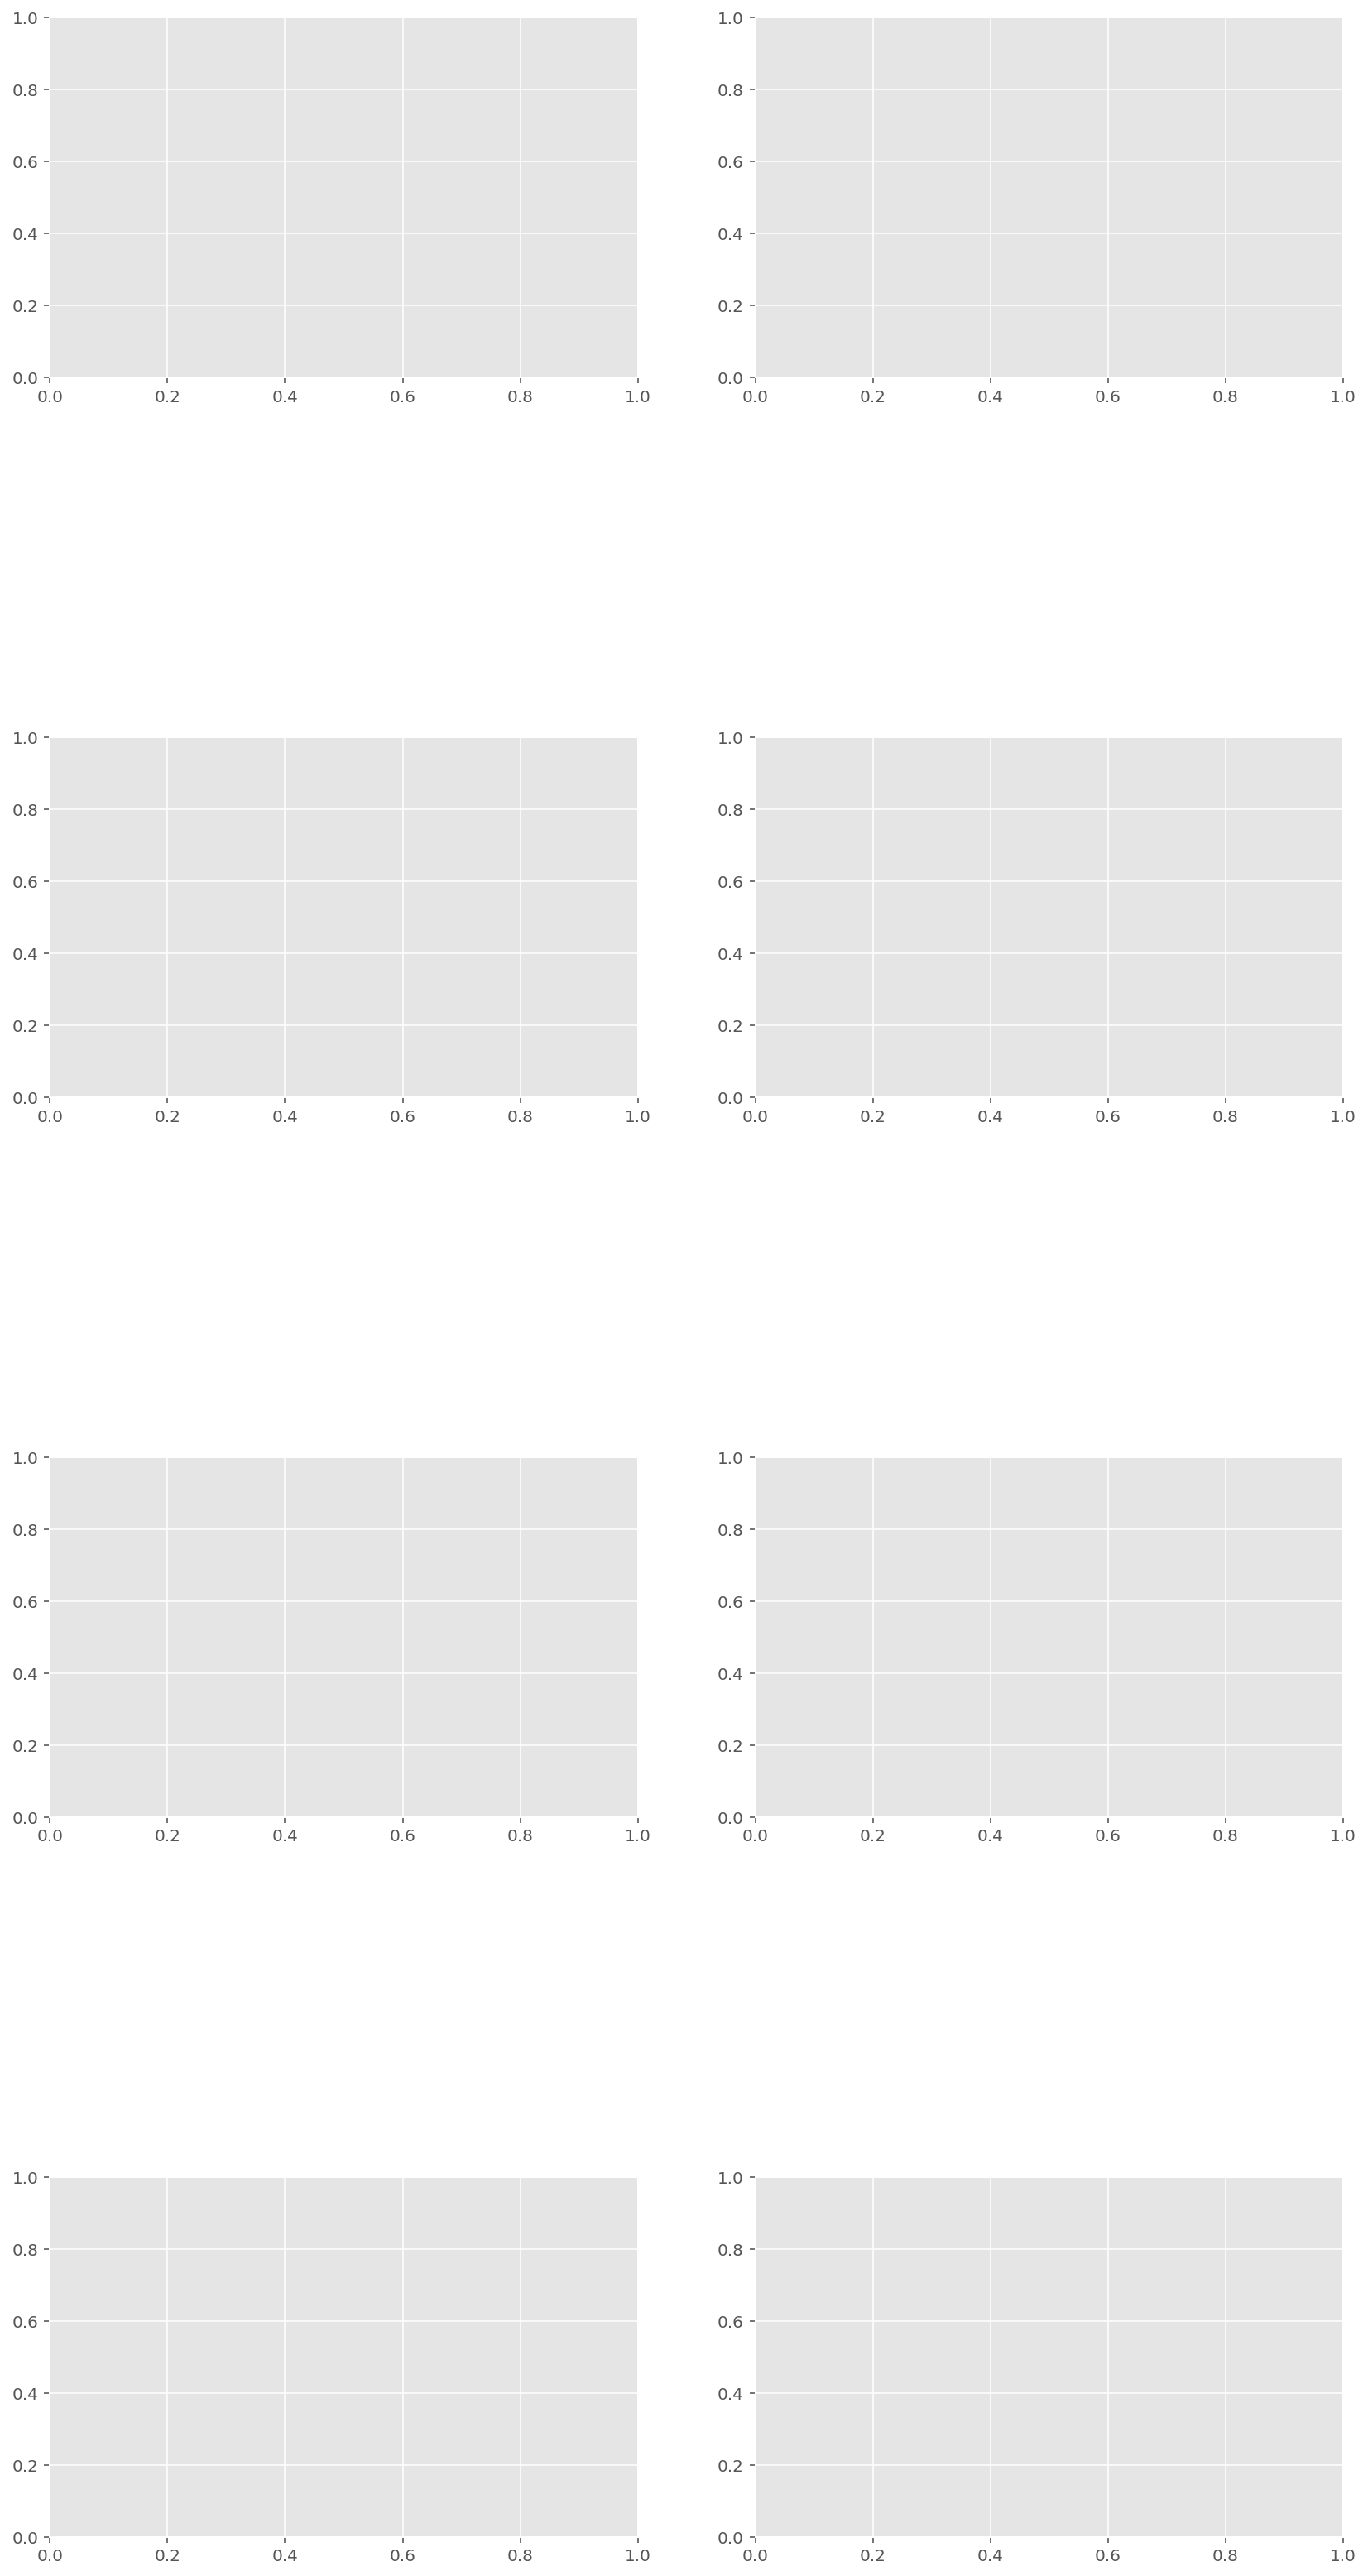

In [18]:
#Did not do this for 2020, no previous year's data. Updated for use in 2021.

compare_years_catagorical(data, ['Native', 'RWQCB_Permit_Hydro',
       'RWQCB_Permit_ACOE_Hydro', 'Cal_IPC_Rating','Habitat', 'HeightCat', 'Observer1'], '2020','2021')

In [19]:
QAQC_attachment_filenames(feature_service)


No mislabeled photos found for layer/table SAC_Both_WR_Woody_Cover

No attachments for layer/table SAC_Both_Woody_Cover_Records


In [20]:
data

,PointID,Habitat,BHR_Site,Observer1,Observer2,SurveyDate,FldPntTyp,Comments,PlotCode,Azimuth,Year,SHAPE,RecordID,HeightCat,Species__scientific_name_,Cal_IPC_Rating,Native,RWQCB_Permit_Hydro,RWQCB_Permit_ACOE_Hydro,RecordGlobalID,Woody,Observation_Date
0,1268,(New) Willow Riparian,SAC,Kurt Lutz,Roger Stephens,2021-08-03 02:31:18,Intended Habitat,Dead SALLAS for ht cat 2 and 3.,NEWR2,294,2020-2021,"{'x': 6184233.459057465, 'y': 2036877.5853543878, 'spatialReferenc...",101,1,Bare Ground (none),None,None,None,None,49b343e3-805f-45c8-aa26-553e528f9b10,None,2021-08-03 02:31:18
1,1270,(New) Willow Riparian,SAC,Kurt Lutz,Roger Stephens,2021-08-03 02:46:23,Intended Habitat,None,NEWR4,32,2020-2021,"{'x': 6184432.847110137, 'y': 2036899.3408883065, 'spatialReferenc...",107,3,Salix laevigata,None,True,True,True,0dff7996-aea4-4ca5-8eca-d3c8e3ff61e3,True,2021-08-03 02:46:23
2,1270,(New) Willow Riparian,SAC,Kurt Lutz,Roger Stephens,2021-08-03 02:46:23,Intended Habitat,None,NEWR4,32,2020-2021,"{'x': 6184432.847110137, 'y': 2036899.3408883065, 'spatialReferenc...",108,2,Salix laevigata,None,True,True,True,bc2959da-c0c6-4d4c-8b04-e3637283f89e,True,2021-08-03 02:46:23
3,1270,(New) Willow Riparian,SAC,Kurt Lutz,Roger Stephens,2021-08-03 02:46:23,Intended Habitat,None,NEWR4,32,2020-2021,"{'x': 6184432.847110137, 'y': 2036899.3408883065, 'spatialReferenc...",109,3,Salix lasiolepis,None,True,True,True,7640d1ca-bba2-4b75-95de-c64bd4115819,True,2021-08-03 02:46:23
4,1273,(New) Willow Riparian,SAC,Roger Stephens,Kurt Lutz,2021-08-03 00:05:59,Intended Habitat,None,NEWR7,313,2020-2021,"{'x': 6184866.362319216, 'y': 2037310.714409396, 'spatialReference...",118,2,Salix lasiolepis,None,True,True,True,58fc5728-3bdd-4d50-b9cf-eab40271963a,True,2021-08-03 00:05:59
5,1273,(New) Willow Riparian,SAC,Roger Stephens,Kurt Lutz,2021-08-03 00:05:59,Intended Habitat,None,NEWR7,313,2020-2021,"{'x': 6184866.362319216, 'y': 2037310.714409396, 'spatialReference...",119,3,Salix lasiolepis,None,True,True,True,3f235e6f-798f-4998-bb72-d2e4a078ef5e,True,2021-08-03 00:05:59
6,1276,(New) Willow Riparian,SAC,Kurt Lutz,Roger Stephens,2021-08-03 02:21:46,Intended Habitat,None,NEWR10,269,2020-2021,"{'x': 6184194.263269722, 'y': 2036928.415633306, 'spatialReference...",97,3,Salix laevigata,None,True,True,True,e43263dc-2c20-44e1-916f-e9bd711c158f,True,2021-08-03 02:21:46
7,1277,(New) Willow Riparian,SAC,Kurt Lutz,Roger Stephens,2021-08-03 02:19:43,Intended Habitat,None,NEWR11,126,2020-2021,"{'x': 6184183.120575473, 'y': 2036915.3812105656, 'spatialReferenc...",96,3,Salix laevigata,None,True,True,True,909ac5f6-a266-4ad8-8946-5b2889c17916,True,2021-08-03 02:19:43
8,1280,(New) Willow Riparian,SAC,Roger Stephens,Kurt Lutz,2021-08-02 23:57:27,Intended Habitat,None,NEWR14,242,2020-2021,"{'x': 6184982.574029058, 'y': 2037406.8421698958, 'spatialReferenc...",113,2,Salix lasiolepis,None,True,True,True,52c7b542-4052-4b71-956e-bdc28aebf1b4,True,2021-08-02 23:57:27
9,1280,(New) Willow Riparian,SAC,Roger Stephens,Kurt Lutz,2021-08-02 23:57:27,Intended Habitat,None,NEWR14,242,2020-2021,"{'x': 6184982.574029058, 'y': 2037406.8421698958, 'spatialReferenc...",114,3,Salix lasiolepis,None,True,True,True,f9af1ec0-4836-43ad-9d22-4fedb554c034,True,2021-08-02 23:57:27


# Analysis

In [21]:
#Convert string to boolean for presence/absence columns
sub['Woody'] = (sub['Woody']=='True')

In [22]:
#Remove unintended habitat points
sub = sub.loc[sub["FldPntTyp"]=="Intended Habitat",:]

In [23]:
#Convert string to boolean for presence/absence columns
sub['Native'] = (sub['Native']=='True')
sub['RWQCB_Permit_ACOE_Hydro'] = (sub['RWQCB_Permit_ACOE_Hydro']=='True')
sub['RWQCB_Permit_Hydro'] = (sub['RWQCB_Permit_Hydro']=='True')

In [24]:
# Count of points
pointCount = sub.groupby('Habitat').PlotCode.nunique()
print("Count of Points:\n")
print(pointCount, '\n\n')

print("Total Count:\n", pointCount.sum())

Count of Points:

Habitat
(New) Willow Riparian    22
Name: PlotCode, dtype: int64 


Total Count:
 22


In [25]:
# Count of plots with native matches
print("Count of plots with native plants:")
print(sub.groupby('PlotCode').Native.any().sum())

# Count of plots with native matches by habitat
print("\nCount of plots with native plants by habitat:")
Count_by_ID_Hab = sub.groupby(['PlotCode','Habitat']).Native.any()
nHits = Count_by_ID_Hab.groupby(['Habitat']).sum()
print(nHits.to_string())

# Native % of observations
print("\nNative Vegetation Cover (%) by Habitat:\n")
print ((nHits/pointCount)*100)

Count of plots with native plants:
21

Count of plots with native plants by habitat:
Habitat
(New) Willow Riparian    21

Native Vegetation Cover (%) by Habitat:

Habitat
(New) Willow Riparian    95.454545
dtype: float64


In [26]:
#RWQCB Permit Hydrophytic cover
print("  Count of plots with RWQCB Permit Hydro Natives:")
print(sub.groupby('PlotCode').RWQCB_Permit_Hydro.any().sum())

# RWQCB hydro native count grouped by the habitat. 
Count_by_ID_Hab = sub.groupby(['PlotCode','Habitat']).RWQCB_Permit_Hydro.any()
hydroHits =  Count_by_ID_Hab.groupby(['Habitat']).sum()
print("\n \n  Count of RWQCB Permit Hydro Native by Habitat: \n")
print(hydroHits.to_string(index=True))

# Native % of observations
print("\n\n  Absolute Native Hydrophytic Plant Cover by Habitat (%):\n")
print(round((hydroHits / pointCount ) * 100,2).to_string(index=True))

  Count of plots with RWQCB Permit Hydro Natives:
20

 
  Count of RWQCB Permit Hydro Native by Habitat: 

Habitat
(New) Willow Riparian    20


  Absolute Native Hydrophytic Plant Cover by Habitat (%):

Habitat
(New) Willow Riparian    90.91


In [27]:
# Count of plots with woody matches
print("Count of plots with woody plants:")
print(sub.groupby('PlotCode').Woody.any().sum())

# Count of plots with native matches by habitat
print("\nCount of plots with woody plants by habitat:")
Count_by_ID_Hab = sub.groupby(['PlotCode','Habitat']).Woody.any()
nHits = Count_by_ID_Hab.groupby(['Habitat']).sum()
print(nHits.to_string())

# % of sampling sites that contained a woody plant (Max 1 hit per pole, N = count of  poles)
print("\n% of sampling sites that contained a woody plant:\n")
print (round((nHits/pointCount)*100,2).to_string(index=True))

Count of plots with woody plants:
21

Count of plots with woody plants by habitat:
Habitat
(New) Willow Riparian    21

% of sampling sites that contained a woody plant:

Habitat
(New) Willow Riparian    95.45


In [28]:
# Count of woody plants by habitat
total_by_ID_Hab = sub.groupby(['PlotCode','Habitat']).Woody.sum()
totalHits = total_by_ID_Hab.groupby(['Habitat']).sum()
print(totalHits.to_string())

# % Cover of woody plants (Max 3 hits per pole, N = count of poles)
print('\nWoody Vegetation (%) by Habitat (Max 3 hits per pole, N = count of poles):')
print(round((totalHits/pointCount)*100,2).to_string(index=True))

Habitat
(New) Willow Riparian    40

Woody Vegetation (%) by Habitat (Max 3 hits per pole, N = count of poles):
Habitat
(New) Willow Riparian    181.82


In [29]:
# Count of woody plants by habitat
total_by_ID_Hab = sub.groupby(['PlotCode','Habitat']).Woody.sum()
totalHits = total_by_ID_Hab.groupby(['Habitat']).sum()
print(totalHits.to_string())

# % of height category observations that contain woody plants (Max 3 hits per pole, N = count of poles * 3)
print('\n% of height category observations that contain woody plants (Max 3 hits per pole, N = count of poles * 3):')
print(round((totalHits/(pointCount*3))*100,2).to_string(index=True))

Habitat
(New) Willow Riparian    40

% of height category observations that contain woody plants (Max 3 hits per pole, N = count of poles * 3):
Habitat
(New) Willow Riparian    60.61


In [30]:
# % of sampling sites that contain plant species (1 max plant per site)
uniqueSpec = sub.groupby(['Habitat','PlotCode','Species__scientific_name_']).BHR_Site.nunique()
sampling_sites_cover = uniqueSpec.groupby(['Habitat','Species__scientific_name_']).sum()/pointCount
sampling_sites_cover

Habitat                Species__scientific_name_
(New) Willow Riparian  Baccharis pilularis          0.045455
                       Baccharis salicifolia        0.090909
                       Bare Ground (none)           0.045455
                       Other (see comments)         0.045455
                       Salix exigua                 0.181818
                       Salix laevigata              0.272727
                       Salix lasiolepis             0.545455
dtype: float64

In [31]:
#Pivot data for plotting
pivot_SSC = pd.DataFrame(sampling_sites_cover).reset_index().pivot(index='Species__scientific_name_',columns='Habitat',values=0)

#Extract only CCRS and WR, and sort by willow riparian
dfp = pivot_SSC.loc[:,['Central Coast Riparian Scrub','Willow Riparian']].sort_values(by='Willow Riparian',ascending=False).dropna(how='all')

#Plot
dfp.plot.bar(figsize=(15,8),title='% of sampling sites that contain plant species')

KeyError: "None of [Index(['Central Coast Riparian Scrub', 'Willow Riparian'], dtype='object', name='Habitat')] are in the [columns]"

In [32]:
# % of hieght category observations that contain plants (Max 3 hits per pole, N = count of poles * 3)
countSpec = sub.groupby(['Habitat','PlotCode','Species_scientific_name_']).Species_scientific_name_.count()
height_as_obs = countSpec.groupby(['Habitat','Species_scientific_name_']).sum()/(pointCount*3)
height_as_obs

KeyError: 'Species_scientific_name_'

In [33]:
#Pivot data for plotting
pivot_height_method = pd.DataFrame(height_as_obs).reset_index().pivot(index='Species_Sci',columns='Habitat',values=0)
pivot_height_method

#Extract only CCRS and WR, and sort by willow riparian, drop blank entries
dfp = pivot_height_method.loc[:,['Central Coast Riparian Scrub','Willow Riparian']].sort_values(by='Willow Riparian',ascending=False).dropna(how='all')

#Plotting
dfp.plot.bar(figsize=(15,8),title='% of height category observations that contain plants')

NameError: name 'height_as_obs' is not defined

In [34]:
# Height Category 1 - % of plots that contain a woody plant
ht1 = sub.loc[sub.HeightCat==1,:]
count_woody_plots = ht1.groupby(['Habitat','PlotCode']).Woody.any()
print('% of height catagory 1 observations that contain a woody plant:')
print(round((count_woody_plots.groupby(['Habitat']).sum()/pointCount)*100,2).to_string(index=True))

# Height Category 2 - % of plots that contain a woody plant
ht2 = sub.loc[sub.HeightCat==2,:]
count_woody_plots = ht2.groupby(['Habitat','PlotCode']).Woody.any()
print('\n\n% of height category 2 observations that contain a woody plant:')
print(round((count_woody_plots.groupby(['Habitat']).sum()/pointCount)*100,2).to_string(index=True))

# Height Category 3 - % of plots that contain a woody plant
ht3 = sub.loc[sub.HeightCat==3,:]
count_woody_plots = ht3.groupby(['Habitat','PlotCode']).Woody.any()
print('\n\n% of height category 3 observations that contain a woody plant:')
print(round((count_woody_plots.groupby(['Habitat']).sum()/pointCount)*100,2).to_string(index=True))

% of height catagory 1 observations that contain a woody plant:
Habitat
(New) Willow Riparian    13.64


% of height category 2 observations that contain a woody plant:
Habitat
(New) Willow Riparian    68.18


% of height category 3 observations that contain a woody plant:
Habitat
(New) Willow Riparian    86.36


In [35]:
sub.head()

,PointID,Habitat,BHR_Site,Observer1,Observer2,SurveyDate,FldPntTyp,Comments,PlotCode,Azimuth,Year,SHAPE,RecordID,HeightCat,Species__scientific_name_,Cal_IPC_Rating,Native,RWQCB_Permit_Hydro,RWQCB_Permit_ACOE_Hydro,RecordGlobalID,Woody,Observation_Date
0,1268,(New) Willow Riparian,SAC,Kurt Lutz,Roger Stephens,2021-08-03 02:31:18,Intended Habitat,Dead SALLAS for ht cat 2 and 3.,NEWR2,294,2020-2021,"{'x': 6184233.459057465, 'y': 2036877.5853543878, 'spatialReferenc...",101,1,Bare Ground (none),None,False,False,False,49b343e3-805f-45c8-aa26-553e528f9b10,False,2021-08-03 02:31:18
1,1270,(New) Willow Riparian,SAC,Kurt Lutz,Roger Stephens,2021-08-03 02:46:23,Intended Habitat,None,NEWR4,32,2020-2021,"{'x': 6184432.847110137, 'y': 2036899.3408883065, 'spatialReferenc...",107,3,Salix laevigata,None,True,True,True,0dff7996-aea4-4ca5-8eca-d3c8e3ff61e3,True,2021-08-03 02:46:23
2,1270,(New) Willow Riparian,SAC,Kurt Lutz,Roger Stephens,2021-08-03 02:46:23,Intended Habitat,None,NEWR4,32,2020-2021,"{'x': 6184432.847110137, 'y': 2036899.3408883065, 'spatialReferenc...",108,2,Salix laevigata,None,True,True,True,bc2959da-c0c6-4d4c-8b04-e3637283f89e,True,2021-08-03 02:46:23
3,1270,(New) Willow Riparian,SAC,Kurt Lutz,Roger Stephens,2021-08-03 02:46:23,Intended Habitat,None,NEWR4,32,2020-2021,"{'x': 6184432.847110137, 'y': 2036899.3408883065, 'spatialReferenc...",109,3,Salix lasiolepis,None,True,True,True,7640d1ca-bba2-4b75-95de-c64bd4115819,True,2021-08-03 02:46:23
4,1273,(New) Willow Riparian,SAC,Roger Stephens,Kurt Lutz,2021-08-03 00:05:59,Intended Habitat,None,NEWR7,313,2020-2021,"{'x': 6184866.362319216, 'y': 2037310.714409396, 'spatialReference...",118,2,Salix lasiolepis,None,True,True,True,58fc5728-3bdd-4d50-b9cf-eab40271963a,True,2021-08-03 00:05:59


In [36]:
sub.loc[sub.Cal_IPC_Rating=='High','NNIP_High'] = True

#RWQCB Permit Hydrophytic cover
print("  Count of plots with a NNIP high:")
print(sub.groupby('PointID').NNIP_High.any().sum())

# NNIP high count grouped by the habitat. 
Count_by_ID_Hab = sub.groupby(['PointID','Habitat']).NNIP_High.any()
highHits =  Count_by_ID_Hab.groupby(['Habitat']).sum()
print("\n \n  Count of plots with a NNIP high by Habitat: \n")
print(highHits.to_string(index=True))

# % of observations
print("\n\n  Absolute NNIP hig Cover by Habitat:\n")
print(round((highHits / pointCount ) * 100,2).to_string(index=True))


  Count of plots with a NNIP high:
0

 
  Count of plots with a NNIP high by Habitat: 

Habitat
(New) Willow Riparian    0


  Absolute NNIP hig Cover by Habitat:

Habitat
(New) Willow Riparian    0.0


In [37]:
def rel_abun(data):
    # Count how many NNIP observations per plot (excluding double hits on same pole)
    plot_obs = data.groupby(['Year','PlotCode','Species__scientific_name_']).BHR_Site.nunique().reset_index()
    
    # Abundance 
    abun = plot_obs.groupby(['Year','Species__scientific_name_']).BHR_Site.sum()
    
    # Count of observations across site (exluding double hits on same pole)
    total_obs = abun.groupby(['Year']).sum()
    
    #Relative abundance
    rel_abun = abun / total_obs
    rel_abun = rel_abun.rename('rel_abun')
    
    #Data manipulation
    #Reset index
    rel_abun_df = rel_abun.reset_index()
    
    #Pivot data
    pivot_df = rel_abun_df.pivot(index='Year', columns='Species__scientific_name_', values='rel_abun')

    #fill NA with 0s
    pivot_df = pivot_df.fillna(0)
    
    return pivot_df

In [38]:
rel_abun(data)

Species__scientific_name_,Baccharis pilularis,Baccharis salicifolia,Bare Ground (none),Other (see comments),Salix exigua,Salix laevigata,Salix lasiolepis
Year,,,,,,,
2020-2021,0.037037,0.074074,0.037037,0.037037,0.148148,0.222222,0.444444


# Export Data Deliverable

In [37]:
data = data.rename(columns={'PointID':'Point ID','RecordID':'Record ID','RecordGlobalID':'Record Global ID'})

In [38]:
data.columns

Index(['Point ID', 'Habitat', 'BHR_Site', 'Observer1', 'Observer2',
       'SurveyDate', 'FldPntTyp', 'Comments', 'PlotCode', 'Azimuth', 'Year',
       'SHAPE', 'Record ID', 'HeightCat', 'Species__scientific_name_',
       'Cal_IPC_Rating', 'Native', 'RWQCB_Permit_Hydro',
       'RWQCB_Permit_ACOE_Hydro', 'Record Global ID', 'Woody',
       'Observation_Date'],
      dtype='object')

In [39]:
del data['SurveyDate']

In [40]:
data.columns

Index(['Point ID', 'Habitat', 'BHR_Site', 'Observer1', 'Observer2',
       'FldPntTyp', 'Comments', 'PlotCode', 'Azimuth', 'Year', 'SHAPE',
       'Record ID', 'HeightCat', 'Species__scientific_name_', 'Cal_IPC_Rating',
       'Native', 'RWQCB_Permit_Hydro', 'RWQCB_Permit_ACOE_Hydro',
       'Record Global ID', 'Woody', 'Observation_Date'],
      dtype='object')

In [41]:
field_order = ([
    'BHR_Site',
    'Observation_Date',
    'Observer1', 
    'Observer2',
    'PlotCode',
    'Year',
    'HeightCat',
    'Species__scientific_name_',
    'Native',
    'Cal_IPC_Rating', 
    'RWQCB_Permit_ACOE_Hydro', 
    'RWQCB_Permit_Hydro',
    'Woody',
    'Habitat',
    'FldPntTyp',
    'Azimuth', 
    'Comments',
    'Point ID',
    'Record ID',
    'Record Global ID',
    'SHAPE'
])

In [42]:
export_data_deliverable(data, feature_service, field_order )

Exported to Outputs/SAC_New_WR_Woody_Cover_Data_20211028.xlsx
